# Notebook for the Sensitivity analysis of the time simulations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.integrate import ode
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

sns.set()

## Functions

### Model 11

Based on Model 9 from Yurtsev et al. (2013) but includes death in stationary phase and degradation by the sentitive strain

In [2]:
def model11(t, model_state, parms):
    A = model_state[0]
    Nr = np.array(model_state[1])
    Ns = np.array(model_state[2])
    if A <= 0:
        A = 1e-9
    Km = parms.get('Km')
    KmS = parms.get('KmS')
    MIC = parms.get('MIC')
    Vmax = parms.get('Vmax')
    VmaxS = parms.get('VmaxS')
    tlag = parms.get('tlag')
    gR = parms.get('gR')
    gS = parms.get('gS')
    gD = parms.get('gD')
    Nsat = parms.get('Nsat')

    # the derivatives for t < tlag:
    if t < tlag:
        dNrdt = 0
        dNsdt = - gD * Ns * (A>=MIC)
        dAdt = - Vmax * Nr * (A/(A+Km)) - VmaxS * Ns * (A/(A+KmS)) 
    elif Nr + Ns < Nsat:
        dNrdt = gR * Nr
        dNsdt = gS * Ns * (A<MIC) - gD * Ns * (A>=MIC)
        dAdt = - Vmax * Nr * (A/(A+Km)) - VmaxS * Ns * (A/(A+KmS)) 
    else:
        dNrdt = 0
        dNsdt = 0
        dAdt = - Vmax * Nr * (A/(A+Km))

    return np.array([dAdt, dNrdt, dNsdt])

### Function for time simulation

In [3]:
def serial_transfer(model, iterations, Rf, Ai, d, gly, parms):
    timeadd = 0
    sol = []
    yield_gly = parms.get('yield')
    Ni = gly*yield_gly/d
    Nri = Ni*Rf
    Nsi = Ni*(1-Rf)
    params = parms.copy()
    Nsat = gly*yield_gly
    params['Nsat'] = Nsat
    def solout(t, model_state):
        if (model_state[1]+model_state[2])>Nsat:
            return -1
        else:
            sol.append([t, *model_state])
            return 0
    for i in range(0, iterations):
        #set up model
        r = ode(model)
        r.set_integrator('dopri5', nsteps=10000) # Integrator that supports solout
        r.set_initial_value(np.array([Ai, Nri, Nsi]))
        r.set_f_params(params)
        r.set_solout(solout)
        r.integrate(100)
        #adjust the time
        asol = np.array(sol)
        asol[:,0] = asol[:,0] + timeadd
        if i==0:
            totalsol = asol
        else:
            totalsol = np.concatenate((totalsol,asol))
        #reset
        Nri, Nsi = tuple(Ni*np.array(sol[-1][2:])/(sol[-1][2]+sol[-1][3]))
        timeadd += sol[-1][0]
        sol = []
    return totalsol

### Calculate confidence intervals

In [4]:
def confidence_under(timeseries):
    return [np.sort(i)[len(i)//20] for i in np.transpose(timeseries)]

In [5]:
def confidence_over(timeseries):
    return [np.sort(i)[-len(i)//20] for i in np.transpose(timeseries)]

## Parameter distributions

Calculate parameters for lognormal distributions from standard deviations

In [6]:
#Values for lognormal distribution MIC
mu_mic, sigma_mic = 1, 0.5
lnsigma_mic = np.sqrt(np.log( sigma_mic**2 / mu_mic**2 + 1))
lnmu_mic = np.log( mu_mic/np.exp(0.5*lnsigma_mic**2) )

#Values for lognormal distribution Vmax vmax_resistant strain
mu_vmax_res, sigma_vmax_res = 3.1e-4, 9.15e-5
lnsigma_vmax_res = np.sqrt(np.log( sigma_vmax_res**2 / mu_vmax_res**2 + 1))
lnmu_vmax_res = np.log( mu_vmax_res/np.exp(0.5*lnsigma_vmax_res**2) )

#Values for lognormal distribution KM resistant strain
mu_res, sigma_res = 69, 7
lnsigma_res = np.sqrt(np.log( sigma_res**2 / mu_res**2 + 1))
lnmu_res = np.log( mu_res/np.exp(0.5*lnsigma_res**2) )

#Values for lognormal distribution Vmax vmax_susistant strain
mu_vmax_sus, sigma_vmax_sus = 6.69e-4, 3.36e-4
lnsigma_vmax_sus = np.sqrt(np.log( sigma_vmax_sus**2 / mu_vmax_sus**2 + 1))
lnmu_vmax_sus = np.log( mu_vmax_sus/np.exp(0.5*lnsigma_vmax_sus**2) )

#Values for lognormal distribution KM susceptible strain
mu_sus, sigma_sus = 319, 182
lnsigma_sus = np.sqrt(np.log( sigma_sus**2 / mu_sus**2 + 1))
lnmu_sus = np.log( mu_sus/np.exp(0.5*lnsigma_sus**2) )

#Values for lognormal distribution yield
mu_yield, sigma_yield = 2e9, 1e9
lnsigma_yield = np.sqrt(np.log( sigma_yield**2 / mu_yield**2 + 1))
lnmu_yield = np.log( mu_yield/np.exp(0.5*lnsigma_yield**2) )

In [7]:
seed_value = random.randrange(2**32)

In [8]:
np.random.seed(seed_value)
nrSamples = 1000
sampled = pd.DataFrame({'gD':np.random.normal(1.54, 0.186, nrSamples), 'gR':np.random.normal(0.185, 0.00326, nrSamples), 'gS':np.random.normal(0.19, 0.00219, nrSamples), 'MIC':np.random.lognormal(lnmu_mic, lnsigma_mic, nrSamples), 'Vmax':np.random.lognormal(lnmu_vmax_res, lnsigma_vmax_res, nrSamples), 'Km':np.random.lognormal(lnmu_res, lnsigma_res, nrSamples), 'VmaxS':np.random.lognormal(lnmu_vmax_sus,lnsigma_vmax_sus,nrSamples), 'KmS':np.random.lognormal(lnmu_sus, lnsigma_sus, nrSamples), 'tlag':np.random.normal(8.5,1,nrSamples), 'yield':np.random.lognormal(lnmu_yield, lnsigma_yield, nrSamples)})

In [9]:
sampled

,gD,gR,gS,MIC,Vmax,Km,VmaxS,KmS,tlag,yield
0,1.711929,0.187582,0.189603,0.939387,0.000395,68.474637,0.000490,290.334458,7.769349,1.395114e+09
1,1.329499,0.186886,0.189493,1.847123,0.000250,68.119780,0.000320,302.699470,8.475731,1.816343e+09
2,1.191207,0.181317,0.189866,1.300578,0.000264,69.660099,0.000950,322.151713,8.911497,1.013260e+09
3,1.649275,0.182112,0.193547,0.750269,0.000323,69.224172,0.000769,362.128124,8.041211,1.786756e+09
4,1.692003,0.180039,0.189449,0.345667,0.000561,73.108948,0.001199,1236.649501,6.609065,7.762050e+08
...,...,...,...,...,...,...,...,...,...,...
995,1.843408,0.189891,0.190886,0.424952,0.000263,55.956612,0.000596,107.917209,8.708105,1.952724e+09
996,1.439353,0.183507,0.189218,0.808233,0.000232,78.396455,0.001577,247.324036,9.445491,1.946547e+09
997,1.075642,0.185794,0.192532,0.355516,0.000271,72.262361,0.000984,84.631818,8.985311,1.333168e+09
998,1.946639,0.182863,0.185310,0.766716,0.000437,70.908356,0.000595,725.265600,7.337671,9.859410e+08


In [10]:
sampled_fromfile = pd.read_pickle('data/parameters.pkl')

In [11]:
sampled_fromfile

,gD,gR,gS,MIC,Vmax,Km,VmaxS,KmS,tlag,yield
0,1.356302,0.181280,0.195334,0.893463,0.000351,65.984086,0.000624,270.851258,10.993198,1.236074e+09
1,1.464483,0.185732,0.190249,2.698172,0.000404,79.549268,0.000514,254.482467,9.116845,1.668286e+09
2,1.688875,0.182806,0.189056,0.906473,0.000308,75.263611,0.000148,278.731588,8.727389,2.717171e+09
3,1.614308,0.182988,0.192723,0.665863,0.000193,67.191811,0.001180,300.033454,8.366409,3.232997e+09
4,1.297144,0.186094,0.188800,1.090112,0.000382,63.795693,0.001128,152.775125,9.939091,1.128946e+09
...,...,...,...,...,...,...,...,...,...,...
995,1.866024,0.187804,0.192670,1.016687,0.000157,81.059657,0.000646,477.774775,7.683231,2.218985e+09
996,1.450687,0.186469,0.184613,0.595115,0.000365,52.575499,0.000577,215.455145,9.084766,1.607063e+09
997,2.083776,0.191821,0.189401,0.608369,0.000322,79.010614,0.000698,239.122795,8.737719,1.490572e+09
998,1.754984,0.183859,0.195266,0.832350,0.000240,74.549686,0.000542,413.533550,9.140349,1.127812e+09


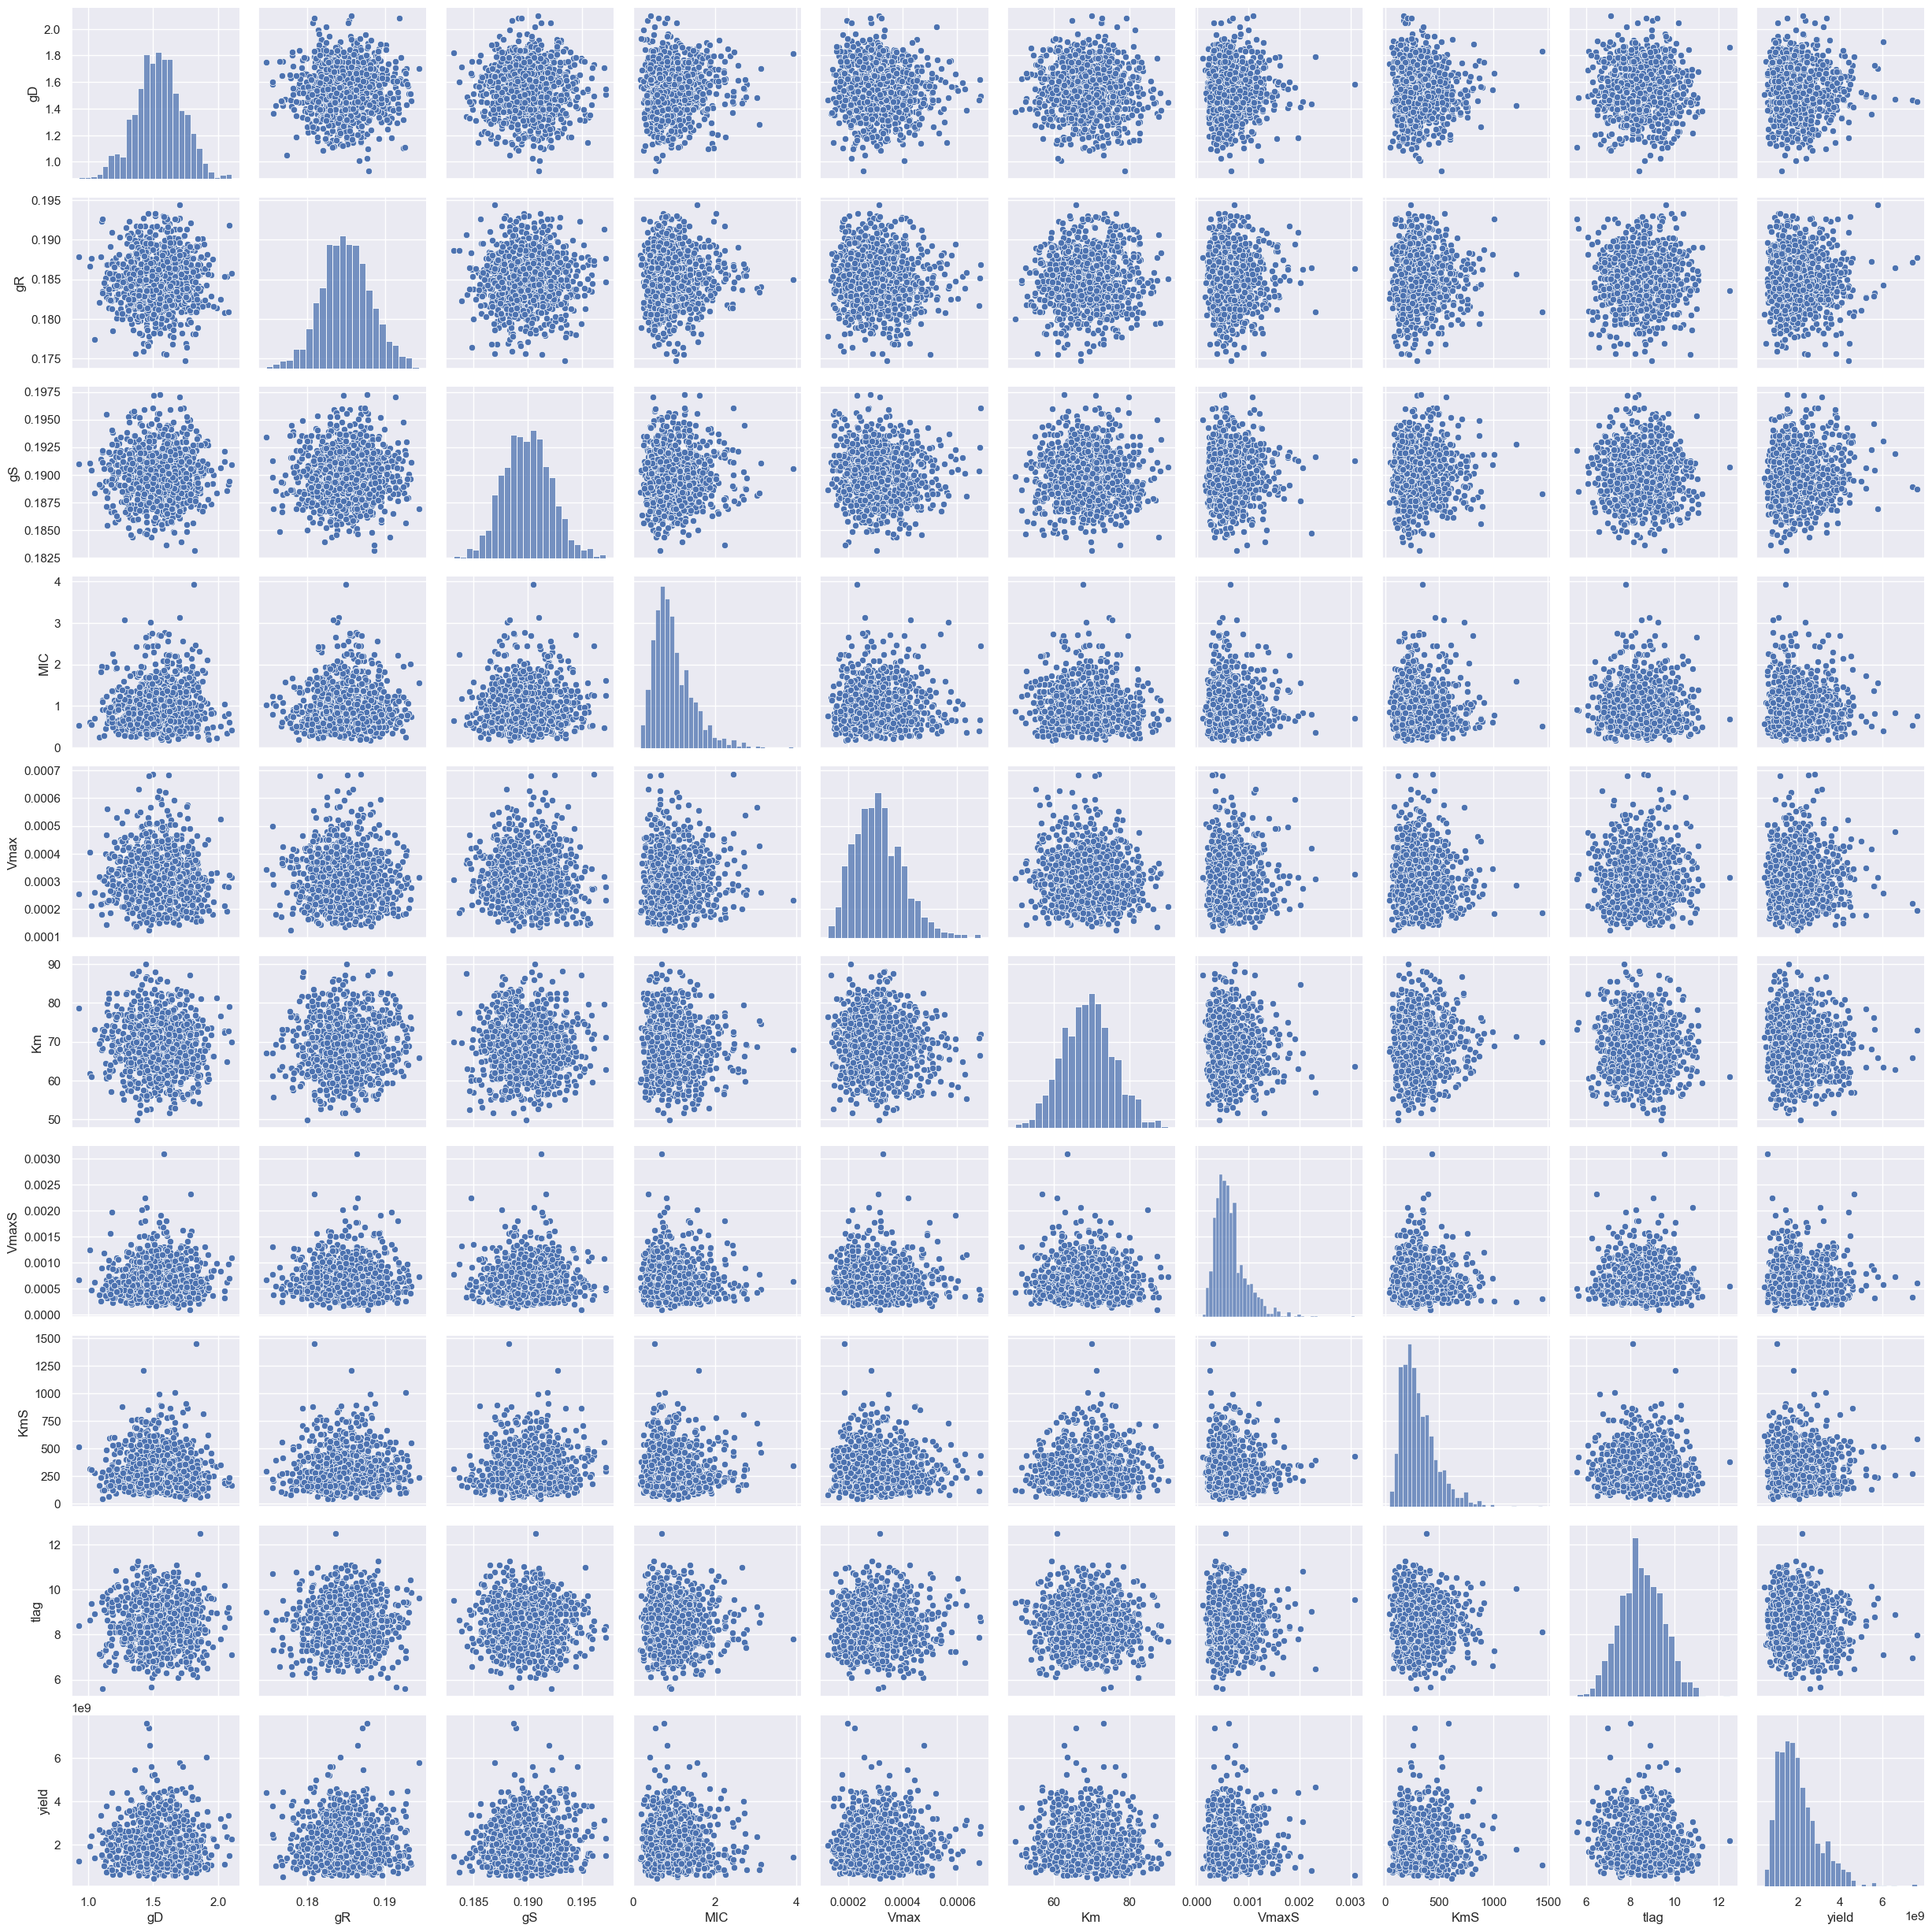

In [12]:
sns.pairplot(sampled_fromfile)

## Basic parameter set and simulation test

In [13]:
# These numbers are from the manuscript
parameters = {'Km': 69, 'MIC': 1, 'Vmax': 3.20e-4, 'tlag':8.5, 'gR': 0.185, 'gS': 0.190, 'gD': 1.54, 'VmaxS': 6.69e-4, 'KmS': 319, 'yield':2e9}

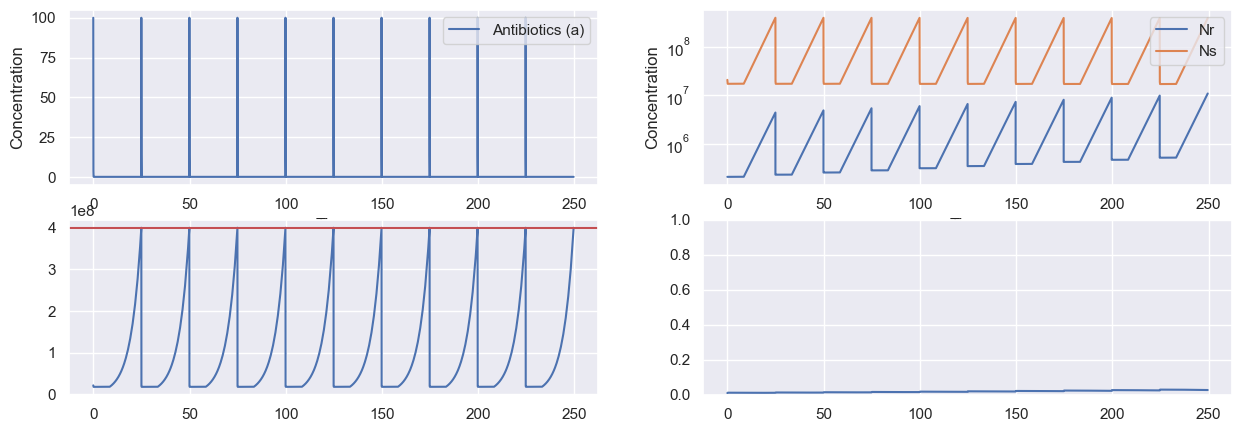

In [14]:
# test if the simulations work
p = parameters
initused = {"Ai": 100, "d": 19, "gly":0.2}

result = serial_transfer(model11, 10, .01, parms=p, **initused)

fig, axes = plt.subplots(2,2, figsize=(15,5))

axes[0,0].plot(result[:,0], result[:,1])
axes[0,1].plot(result[:,0], result[:,2])
axes[0,1].plot(result[:,0], result[:,3])
axes[1,0].plot(result[:,0], result[:,2]+result[:,3])
axes[1,1].plot(result[:,0], result[:,2]/(result[:,2]+result[:,3]))
axes[1,0].axhline(y=initused['gly']*p['yield'], color='r', linestyle='-')

axes[0,0].set_xlabel('Time')
axes[0,1].set_xlabel('Time')
axes[0,0].set_ylabel('Concentration')
axes[0,1].set_ylabel('Concentration')
axes[0,1].set_yscale('log')
axes[1,1].set_ylim([0,1])
axes[0,0].legend(tuple(['Antibiotics (a)']), loc="upper right")
axes[0,1].legend(tuple(['Nr', 'Ns']), loc="upper right")

## Simulations of the experiment

- We first simulate the experiment with the average values
- Then we simulate from the samples parameters
- We save the results of those simulations
- From the simulations of the sampling we calculate the 95% confidence interval
- Then we plot them all together
- We calculate the TMV for a table in the supp info

### Simulation of the experiment with different density at first instance

- 20 times dilution
- 12.5, 25 and 50 ug/ml glycerol
- 0.2, 0.43, 0.93 en 2% glycerol
- Nsat = 2 * 10^9 * percentage_glycerol
- 5 cycles
- 3 startratios of triple: 0.1, 0.5, 0.9
- Ni at first simulation 10 times lower

In [15]:
inits_experiment_first = [{"Ai": a, "d": 200, "gly": g} for a in [12.5, 25, 50] for g in [0.2, 0.43, 0.93, 2]]
inits_experiment = [{"Ai": a, "d": 20, "gly": g} for a in [12.5, 25, 50] for g in [0.2, 0.43, 0.93, 2]]

In [16]:
p = parameters
nrsim = 15

sim_experiment_first = [[serial_transfer(model11, 2, .1, parms=p, **i),serial_transfer(model11, 2, .5, parms=p, **i),serial_transfer(model11, 2, .9, parms=p, **i)] for i in inits_experiment_first]

temp_ratios = np.zeros((len(inits_experiment_first), 3))
for i in range(len(inits_experiment_first)):
    for r in [0,1,2]:
        temp_ratios[i,r] = [x[2]/(x[2]+x[3]) for x in sim_experiment_first[i][r] if x[1] == inits_experiment_first[i]["Ai"]][-1]
        
sim_experiment_second = [[serial_transfer(model11, nrsim-1, r[0], parms=p, **i),serial_transfer(model11, nrsim-1, r[1], parms=p, **i),serial_transfer(model11, nrsim-1, r[2], parms=p, **i)] for (i, r) in zip(inits_experiment, temp_ratios)]     
        

C:\Users\meike\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


C:\Users\meike\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


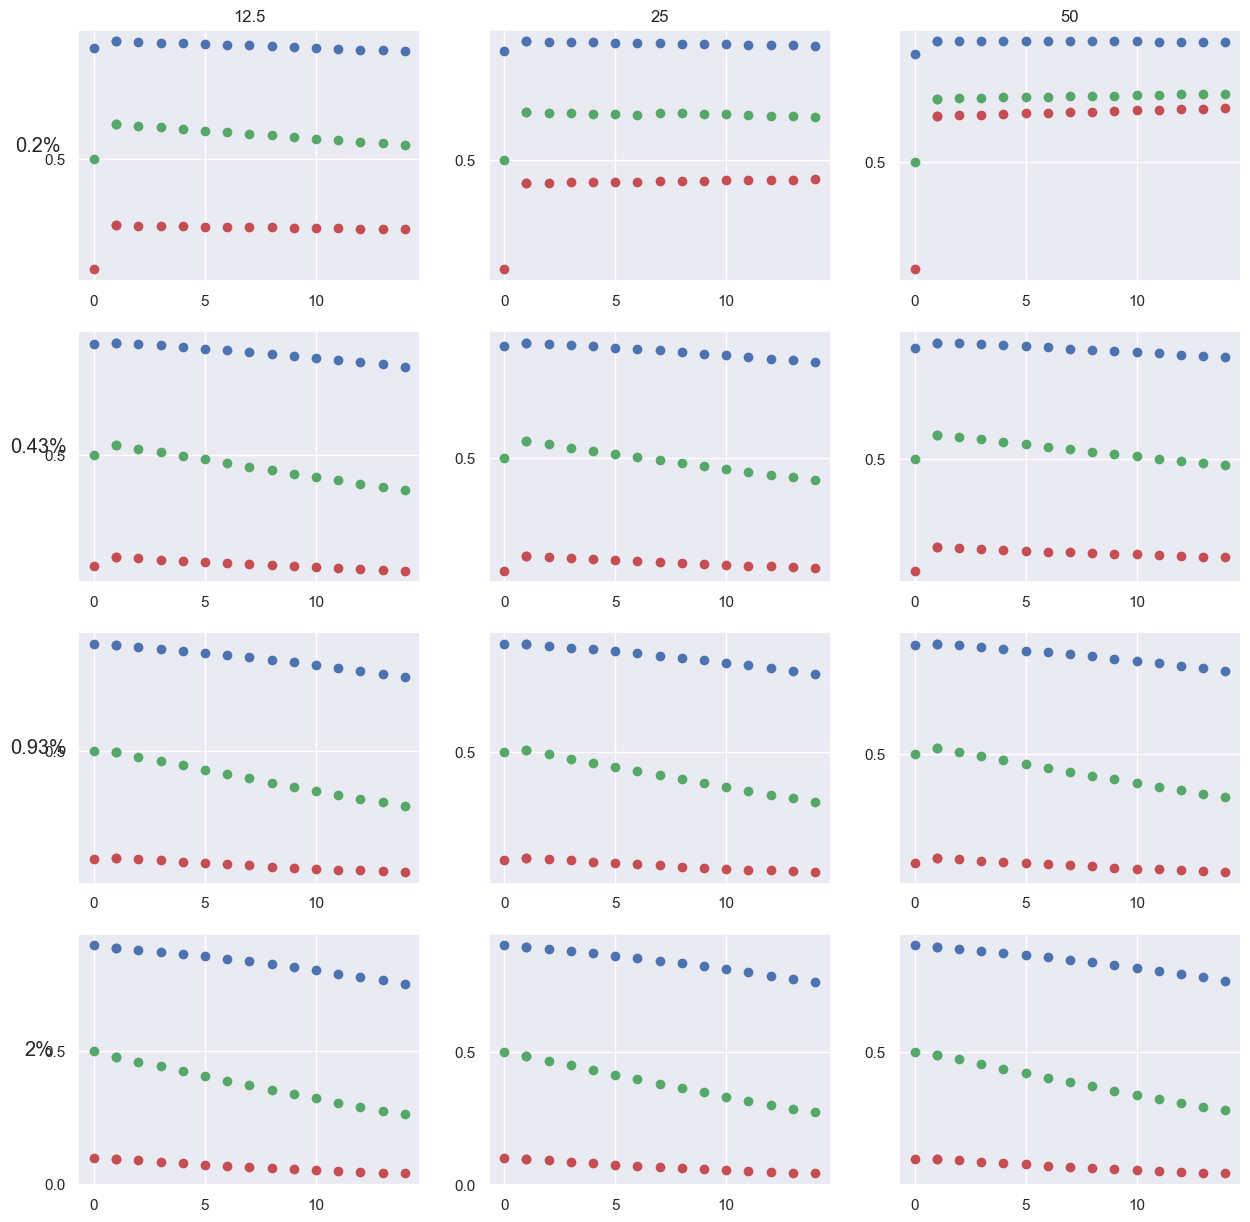

In [17]:
fig, axes = plt.subplots(4,3, figsize=(15,15))
colors = ['r', 'g', 'b']

cols = [12.5, 25, 50]
rows = ['0.2%', '0.43%', '0.93%', '2%']

for i in range(len(inits_experiment_first)):
    for r in [0,1,2]:
        start = [x[2]/(x[2]+x[3]) for x in sim_experiment_first[i][r] if x[1] == inits_experiment_first[i]["Ai"]]
        axes[i%4][i//4].scatter(range(2),start,color=colors[r])
    axes[i%4][i//4].set_yticks([0, 0.5, 1])
    axes[i%4][i//4].set_xticks([0, 5, 10,15])

for i in range(len(inits_experiment_first)):
    for r in [0,1,2]:
        start = [x[2]/(x[2]+x[3]) for x in sim_experiment_second[i][r] if x[1] == inits_experiment_first[i]["Ai"]]
        axes[i%4][i//4].scatter(range(1, nrsim),start,color=colors[r])
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
fig.show()
#plt.savefig("timesim_diff_first.jpg")

### Simulate the sampled datasets

This takes time and is now set to only a subset as an example

In [21]:
sampled_subset = sampled[0:100]

In [22]:
inits_sim = [{"Ai": a, "d": 20, "gly": g} for a in [12.5, 25, 50] for g in [0.2, 0.43, 0.93, 2]]
inits_sim_test = [{"Ai": a, "d": 20, "gly": g} for a in [50] for g in [0.2,2]]

In [63]:
#simulate an experiment with parameters from the dataframe

#set the initial conditions to be used
init_used = inits_sim_test

#set the parameter sets to be used
samples_used = sampled_subset

nrsim = 15

sampling_simulations = []

for i in init_used:
    sim_res_temp = []
    for r in [.1,.5,.9]:
        sim_res_temp_ratio = []
        for p in samples_used.to_dict(orient='records'):
            i_first = i.copy()
            i_first["d"] = 200
            result = serial_transfer(model11, 2, r, parms=p, **i_first)
            start = [x[2]/(x[2]+x[3]) for x in result if x[1] == i["Ai"]]
            result = serial_transfer(model11, nrsim-1, start[-1], parms=p, **i)
            start = ([x[2]/(x[2]+x[3]) for x in result if x[1] == i["Ai"]])
            start.insert(0,r)
            sim_res_temp_ratio.append(start)
        sim_res_temp.append(sim_res_temp_ratio)
    sampling_simulations.append(sim_res_temp)

sampling_simulations = np.array(sampling_simulations)

#### Calculate conficence intervals

In [64]:
sampling_under_subset = np.array([[confidence_under(ratio) for ratio in init] for init in sampling_simulations])

In [65]:
sampling_over_subset = np.array([[confidence_over(ratio) for ratio in init] for init in sampling_simulations])

#### Plot confidence intervals

C:\Users\meike\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


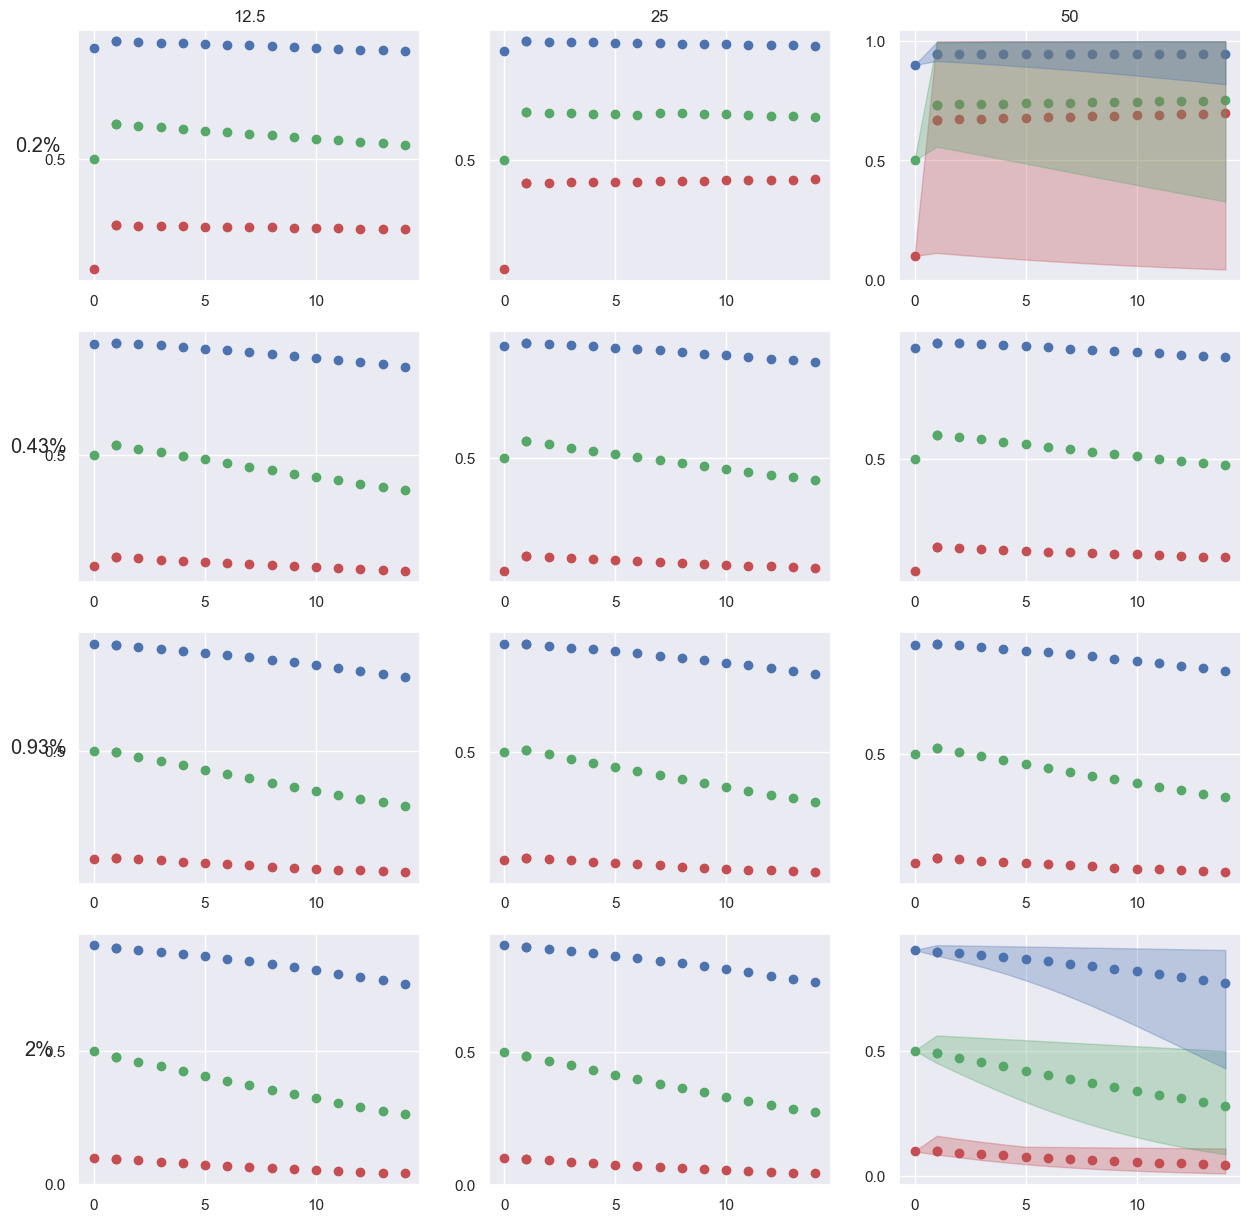

In [66]:
inits = inits_sim

fig, axes = plt.subplots(4,3, figsize=(15,15))
colors = ['r', 'g', 'b']

cols = [12.5, 25, 50]
rows = ['0.2%', '0.43%', '0.93%', '2%']

for i in range(len(inits_experiment_first)):
    for r in [0,1,2]:
        start = [x[2]/(x[2]+x[3]) for x in sim_experiment_first[i][r] if x[1] == inits_experiment_first[i]["Ai"]]
        axes[i%4][i//4].scatter(range(2),start,color=colors[r])
    axes[i%4][i//4].set_yticks([0, 0.5, 1])
    axes[i%4][i//4].set_xticks([0, 5, 10,15])

for i in range(len(inits_experiment_first)):
    for r in [0,1,2]:
        start = [x[2]/(x[2]+x[3]) for x in sim_experiment_second[i][r] if x[1] == inits_experiment_first[i]["Ai"]]
        axes[i%4][i//4].scatter(range(1, nrsim),start,color=colors[r])
    
for i in range(2):
    if i == 0:
        ia = 8
    elif i == 1:
        ia = 11
    for r in [0,1,2]:
        axes[ia%4][ia//4].fill_between(range(nrsim),sampling_under_subset[i][r],sampling_over_subset[i][r],color=colors[r], alpha=0.3)

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
fig.show()

### Load simulations that have been simulated on a High Performance Cluster

In [25]:
sim_res_cluster_1 = np.load('data/results_sampling_simulation_first.npy')
sim_res_cluster_2  = np.load('data/results_sampling_simulation_second_old.npy')
sim_res_cluster = np.concatenate((sim_res_cluster_1, sim_res_cluster_2), axis=0)

#### Calculate confidence intervals

In [26]:
sampling_under = np.array([[confidence_under(ratio) for ratio in init] for init in sim_res_cluster])

In [27]:
sampling_over = np.array([[confidence_over(ratio) for ratio in init] for init in sim_res_cluster])

#### Plot confidence intervals

C:\Users\meike\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


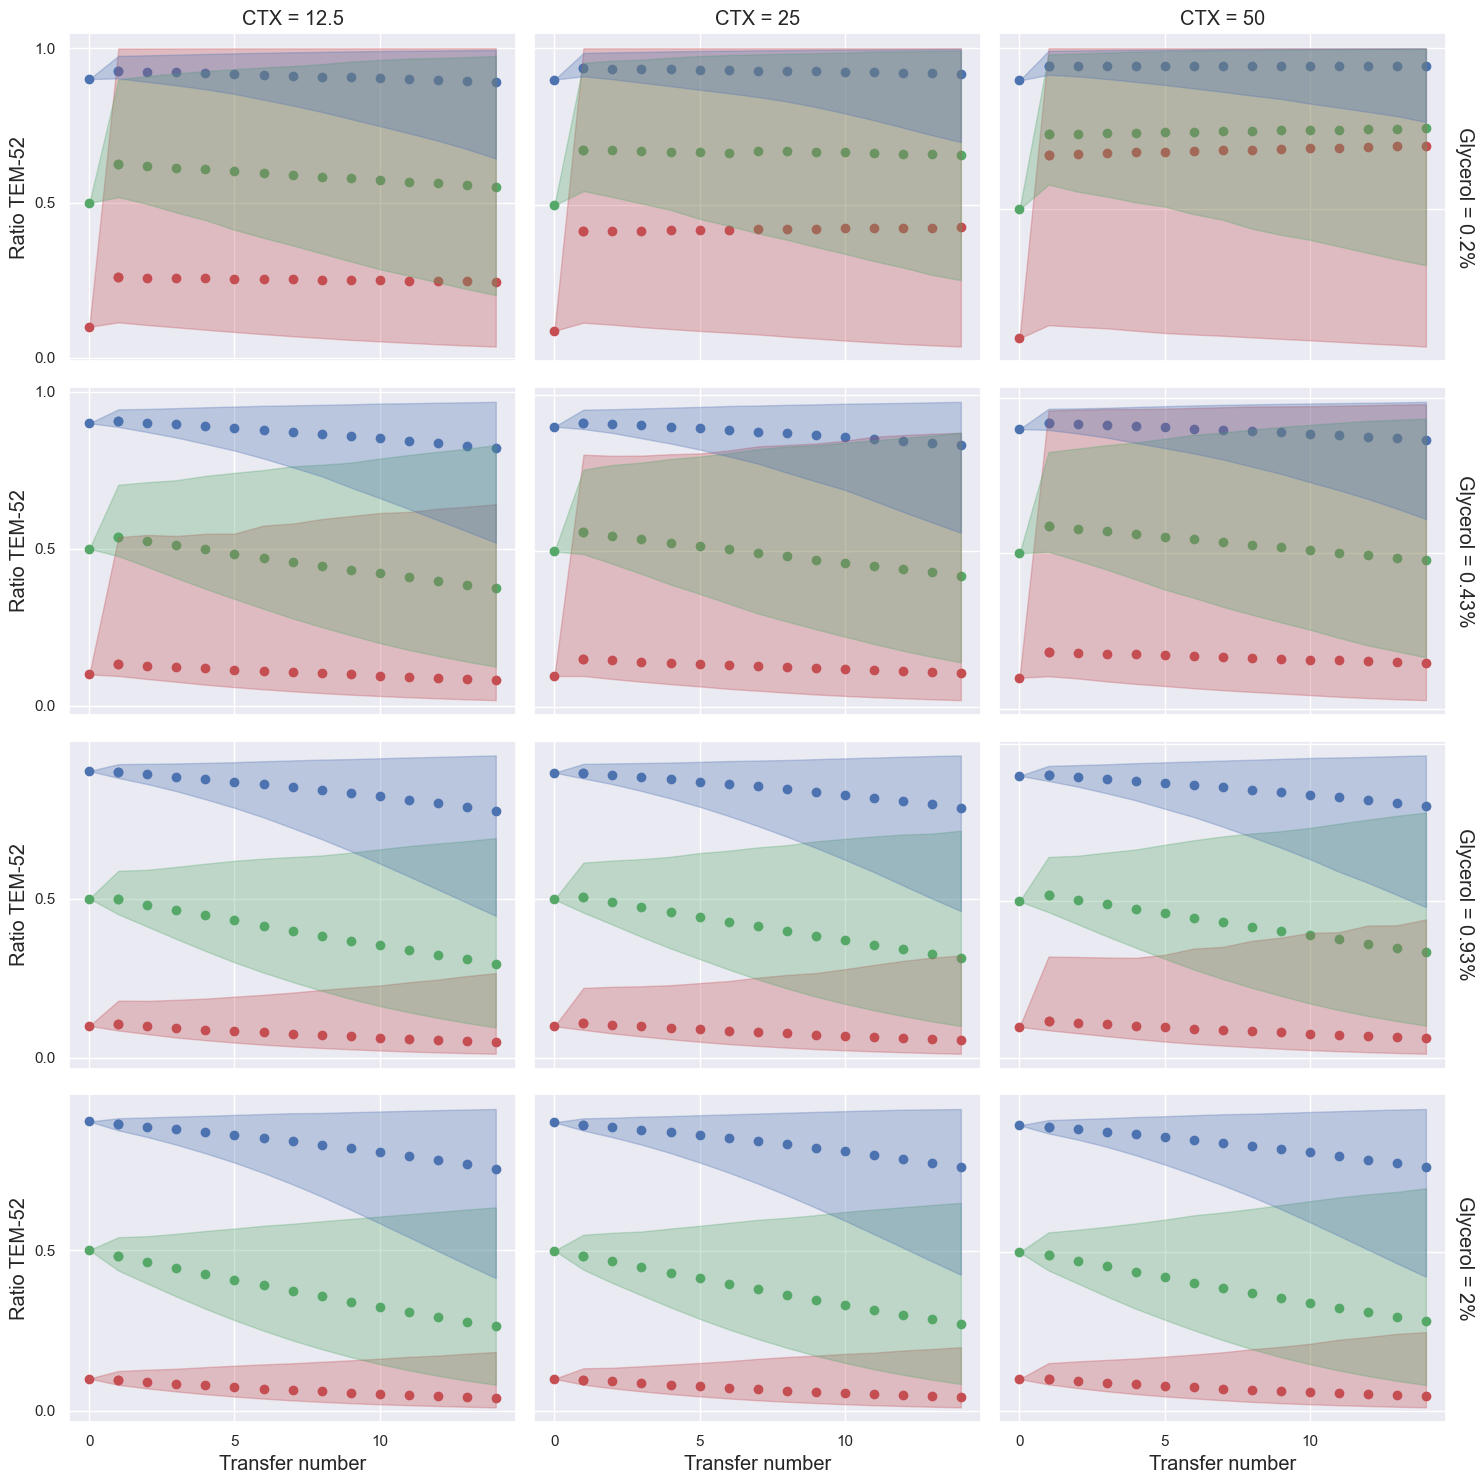

In [62]:
inits = inits_sim

fig, axes = plt.subplots(4,3, figsize=(15,15))
colors = ['r', 'g', 'b']

cols = [12.5, 25, 50]
rows = ['0.2%', '0.43%', '0.93%', '2%']

for i in range(len(inits_experiment_first)):
    for r in [0,1,2]:
        start = [x[2]/(x[2]+x[3]) for x in sim_experiment_first[i][r] if x[1] == inits_experiment_first[i]["Ai"]]
        axes[i%4][i//4].scatter(range(2),start,color=colors[r])
    axes[i%4][i//4].set_yticks([0, 0.5, 1])
    axes[i%4][i//4].set_xticks([0, 5, 10, 15])
    if(i//4==0):
        axes[i%4][i//4].set_ylabel('Ratio TEM-52', size='large')
    else:
        axes[i%4][i//4].tick_params('y', labelleft=False)
    if(i%4==3):
        axes[i%4][i//4].set_xlabel('Transfer number', size='large')
    else:
        axes[i%4][i//4].tick_params('x', labelbottom=False)

for i in range(len(inits_experiment_first)):
    for r in [0,1,2]:
        start = [x[2]/(x[2]+x[3]) for x in sim_experiment_second[i][r] if x[1] == inits_experiment_first[i]["Ai"]]
        axes[i%4][i//4].scatter(range(1, nrsim),start,color=colors[r])
    
for i in range(len(inits)):
    for r in [0,1,2]:
        axes[i%4][i//4].fill_between(range(nrsim),sampling_under[i][r][0:-1],sampling_over[i][r][0:-1],color=colors[r], alpha=0.3)

for ax, col in zip(axes[0], cols):
    ax.set_title('CTX = '+str(col), size='large')

for ax, row in zip(axes[:,2], rows):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('Glycerol = ' + str(row), rotation=-90, labelpad=20, size='large')

plt.tight_layout()
fig.show()
#plt.savefig("timesim_conf.jpg")